In [75]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [76]:
np.random.seed(42)

In [77]:
from dotenv import load_dotenv
load_dotenv()

True

In [78]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key,alpaca_secret_key,api_version="v2")

In [79]:
ticker = ["SPY", "AGG"]
timeframe = "1D"

start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

df = api.get_barset(ticker,timeframe,limit=None,start=start_date,end=end_date,after=None,until=None,).df

df = df.drop(columns=['open', 'high', 'low', 'volume'],level=1)
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


In [80]:
df = df.droplevel(axis=1, level=0)
df.index = df.index.date
df.columns = ['AGG','SPY']
df.head()

,AGG,SPY
2019-01-02,106.585,249.89
2019-01-03,107.020,244.46
2019-01-04,106.695,252.41
2019-01-07,106.470,254.40
2019-01-08,106.420,256.65


In [81]:
daily_returns= df.pct_change()
daily_returns.head()

,AGG,SPY
2019-01-02,NaN,NaN
2019-01-03,0.004081,-0.021730
2019-01-04,-0.003037,0.032521
2019-01-07,-0.002109,0.007884
2019-01-08,-0.000470,0.008844


In [82]:
agg_vol = daily_returns['AGG'].std()
spy_vol = daily_returns['SPY'].std()
agg_mean = daily_returns['AGG'].mean()
spy_mean = daily_returns['SPY'].mean()
last_agg = df['AGG'][-1]
last_spy = df['SPY'][-1]

In [90]:
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_returns = pd.DataFrame()

In [91]:
for n in range(number_simulations):

    
    simulated_agg_prices = [last_agg]
    simulated_spy_prices = [last_spy]
    
   
    for i in range(number_records):
        
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(agg_mean, agg_vol))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(spy_mean, spy_vol))
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
    
    simulated_daily_returns = monte_carlo.pct_change()
    
    weights = [0.40, 0.60]

    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

portfolio_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000475,1.000536,0.998808,1.005395,1.011798,0.994450,0.997249,1.013279,1.000868,0.995375,...,1.002066,0.992708,1.001800,1.002671,0.996472,1.003160,1.001638,1.006801,0.998172,0.994764
2,1.008876,1.004700,1.003591,0.996710,1.009571,0.994245,0.994211,1.007202,1.000225,0.993033,...,1.005759,0.994515,1.003316,1.006181,0.997471,0.991772,1.002764,1.005410,0.996136,0.998870
3,1.008286,1.004228,1.003771,0.998232,1.007751,0.987666,0.998226,1.001363,1.000229,1.001276,...,1.006771,0.988440,1.004116,1.010566,0.993292,0.994452,1.008273,0.999143,0.998654,1.003328
4,1.013962,1.006575,1.008494,1.002635,1.013664,0.990970,1.003240,0.995492,1.002046,1.006035,...,1.004195,0.992120,1.004722,1.004421,0.994842,0.993780,1.005723,1.002247,0.996961,1.004094


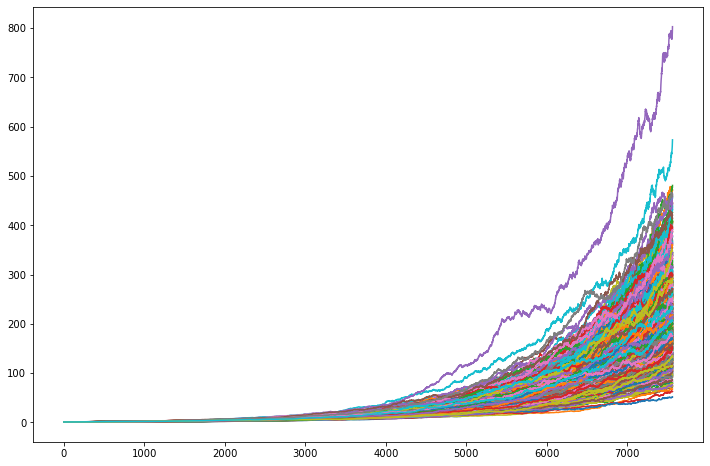

In [92]:
portfolio_returns.plot(legend=False,figsize=(12,8))

In [93]:
ending_returns = portfolio_returns.iloc[-1, :]
ending_returns.head()

0    192.447672
1    171.674293
2    177.691905
3    138.221133
4    175.326232
Name: 7560, dtype: float64

In [94]:
confidence_interval = ending_returns.quantile(q=[0.050, 0.950])

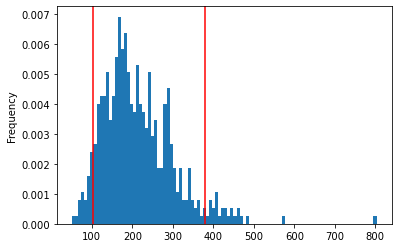

In [95]:
plt.figure();
ending_returns.plot(kind='hist', density=True, bins=100)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [96]:
percentile10 = ending_returns.quantile(q=0.10)
percentile50 = ending_returns.quantile(q=0.50)
percentile90 = ending_returns.quantile(q=0.90)
print(f'Expected Return for the 10th: {percentile10}')
print(f'Expected Return for the 50th: {percentile50}')
print(f'Expected Return for the 90th: {percentile90}')

Expected Return for the 10th: 118.82343482859959
Expected Return for the 50th: 198.76070846181443
Expected Return for the 90th: 320.03700024904253


In [97]:
initial_investment = 20000

investment10= initial_investment + (initial_investment * (ending_returns.quantile(q=0.10)))
investment50= initial_investment + (initial_investment * (ending_returns.quantile(q=0.50)))
investment90= initial_investment + (initial_investment * (ending_returns.quantile(q=0.90)))
print(f'Expected returns for a U$20,000 investiment in the retirement portfolio are {investment10}, {investment50}, {investment90} for the 10th, 50th and 90th percentile respectivelly.')

Expected returns for a U$20,000 investiment in the retirement portfolio are 2396468.696571992, 3995214.1692362884, 6420740.004980851 for the 10th, 50th and 90th percentile respectivelly.


In [98]:
projected_income = 7389 
(investment10 * .04) > projected_income

True

##### The 4% withdraw rate of the 10th percentile is greater than the projected yearly income in the Plaid analysys

In [99]:
initial_investment = 30000

investment10a= initial_investment + (initial_investment * (ending_returns.quantile(q=0.10)))
investment50b= initial_investment + (initial_investment * (ending_returns.quantile(q=0.50)))
investment90c= initial_investment + (initial_investment * (ending_returns.quantile(q=0.90)))
print(f'Expected returns for a U$30,000 investiment in the retirement portfolio are {investment10a}, {investment50b}, {investment90c} for the 10th, 50th and 90th percentile respectivelly.')

Expected returns for a U$30,000 investiment in the retirement portfolio are 3594703.0448579877, 5992821.253854433, 9631110.007471276 for the 10th, 50th and 90th percentile respectivelly.


##### The 4% withdraw rate of the 10th percentile continue to be greater than the projected yearly income in the Plaid analysys¶

In [104]:
########### CHALLENGE

In [110]:
percentile5th = []
percentile50th = []
percentile95th = []
cumulative_returns = pd.DataFrame()

In [111]:
for x in range(number_records):
    per5th = monte_carlo.iloc[x, :].quantile(0.05)
    percentile5th.append(per5th)
    per50th = monte_carlo.iloc[x, :].quantile(0.50)
    percentile50th.append(per50th)
    per95th = monte_carlo.iloc[x, :].quantile(0.95)
    percentile95th.append(per95th)

In [112]:
cumulative_returns["0.05 Quantile"] = pd.Series(percentile5th)
cumulative_returns["0.50 Quantile"] = pd.Series(percentile50th)
cumulative_returns["0.95 Quantile"] = pd.Series(percentile95th)

In [113]:
cumulative_returns.head()

,0.05 Quantile,0.50 Quantile,0.95 Quantile
0,122.846000,217.130000,311.414000
1,122.633411,215.764015,308.894620
2,122.877636,216.791633,310.705630
3,122.914194,218.029887,313.145580
4,123.084372,218.155231,313.226089


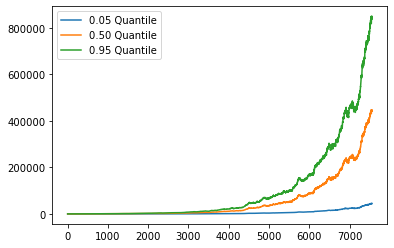

In [114]:
cumulative_returns.plot()